# Different Alpha in the activation functions 

In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from utils_activation_FO import *

# ================= LOAD DATA =================
data = pd.read_csv("signals_FO.csv")

in1 = data['in1'].to_numpy()
in2 = data['in2'].to_numpy()
out = data['out'].to_numpy()

# ================= NARX FORM =================
# X(t) = [in1(t), in2(t), out(t-1)]
# y(t) = out(t)

X = np.column_stack([
    in1[1:],      # in1(t)
    in2[1:],      # in2(t)
    out[:-1]      # out(t-1)
])

y = out[1:]      # out(t)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False
)

# Input scaling
x_scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)

# Output scaling (regresija!)
y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))


In [7]:
# ============== SETUP =============
num_input = 3    # in1(t), in2(t), out(t-1)
num_hidden = 10
num_output = 1   # out(t)
seed2 = 10
# M1 : Classical Activation Functions (ELU)
model_fixed = build_model_identical(num_input, num_hidden, num_output,
                                    activation="relu", seed=seed2)
model_fixed.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

# M2 : Sigmoid with trainable alpha (shared parameter per-layer)
model_trainable = build_model_identical(num_input, num_hidden, num_output,
                                        activation=PerLayerRelu(), seed=seed2)
model_trainable.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)
# M3 : Sigmoid with trainable alpha (per-neuron parameter)
model_adaptable = build_model_different(num_input, num_hidden, num_output, 
                                        bias=True, activation='Relu', seed=seed2)
model_adaptable.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)


In [8]:
# ============== INITIAL ALPHA VALUES ==============
_ = model_fixed.predict(X_train[:1], verbose=0)
_ = model_trainable.predict(X_train[:1], verbose=0)
_ = model_adaptable.predict(X_train[:1], verbose=0)

m2_alpha_before = []
m3_alpha_before = []

for layer in model_trainable.layers:
    if hasattr(layer, 'alpha'):
        m2_alpha_before. append(layer.alpha.numpy().copy())

for layer in model_adaptable.layers:
    if hasattr(layer, 'alpha'):
        m3_alpha_before.append(layer.alpha.numpy().copy())


In [9]:
# ============== TRAINING ==============
EPOCHS = 100
BATCH = 32
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10 ,
        restore_best_weights=True,
        min_delta=1e-4
        )]
history_fixed = model_fixed.fit(X_train, y_train, epochs=EPOCHS,
                                batch_size=BATCH, validation_split=0.2, verbose=0)
history_trainable = model_trainable.fit(X_train, y_train, epochs=EPOCHS,
                                batch_size=BATCH, validation_split=0.2, verbose=0)
history_adaptable = model_adaptable.fit(X_train, y_train, epochs=EPOCHS,
                                batch_size=BATCH, validation_split=0.2, verbose=0)

print("ALPHA COMPARISON (Before vs After)")

print("Shared alpha:")
m2_idx = 0
for layer in model_trainable.layers:
    if hasattr(layer, 'alpha'):
        print(f"Layer '{layer.name}':")
        print(f"Before: {m2_alpha_before[m2_idx]}")
        print(f"After:  {layer.alpha.numpy()}")
        m2_idx += 1
print("\n")
print("Per-neuron alpha:")
m3_idx = 0
for layer in model_adaptable.layers:
    if hasattr(layer, 'alpha'):
        print(f"Layer '{layer.name}':")
        print(f"Before: {m3_alpha_before[m3_idx]}")
        print(f"After:   {layer.alpha.numpy()}")
        m3_idx += 1



ALPHA COMPARISON (Before vs After)
Shared alpha:
Layer 'per_layer_relu_2':
Before: [-0.01346445]
After:  [0.12709242]
Layer 'per_layer_relu_3':
Before: [-0.89633536]
After:  [-0.11190447]


Per-neuron alpha:
Layer 'per_neuron_relu_2':
Before: [-0.18250918 -0.968889   -0.23148513  0.8442023   0.44499373  0.15933132
 -0.97226834 -0.02091527  0.08759141  0.4985044 ]
After:   [ 0.0310915  -0.17713302 -0.00886325  0.27494186  0.4023173   0.04942927
 -0.21011034  0.05279934 -0.03709279  0.27223352]
Layer 'per_neuron_relu_3':
Before: [-0.67326117 -0.3891039  -0.48722386 -0.10189104  0.10732079  0.41914582
 -0.15787649 -0.4148543  -0.6743293  -0.7650356 ]
After:   [-0.13400991 -0.1380741  -0.13178402 -0.26524144  0.13000377  0.28355974
  0.16176386  0.04841876 -0.12835217 -0.48993942]


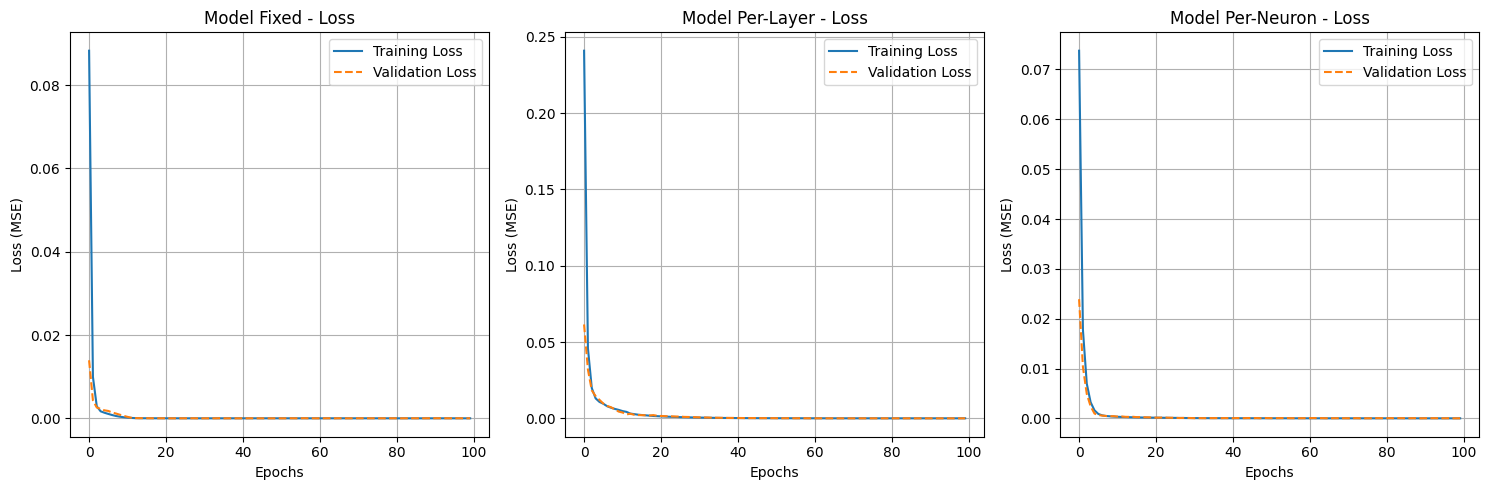

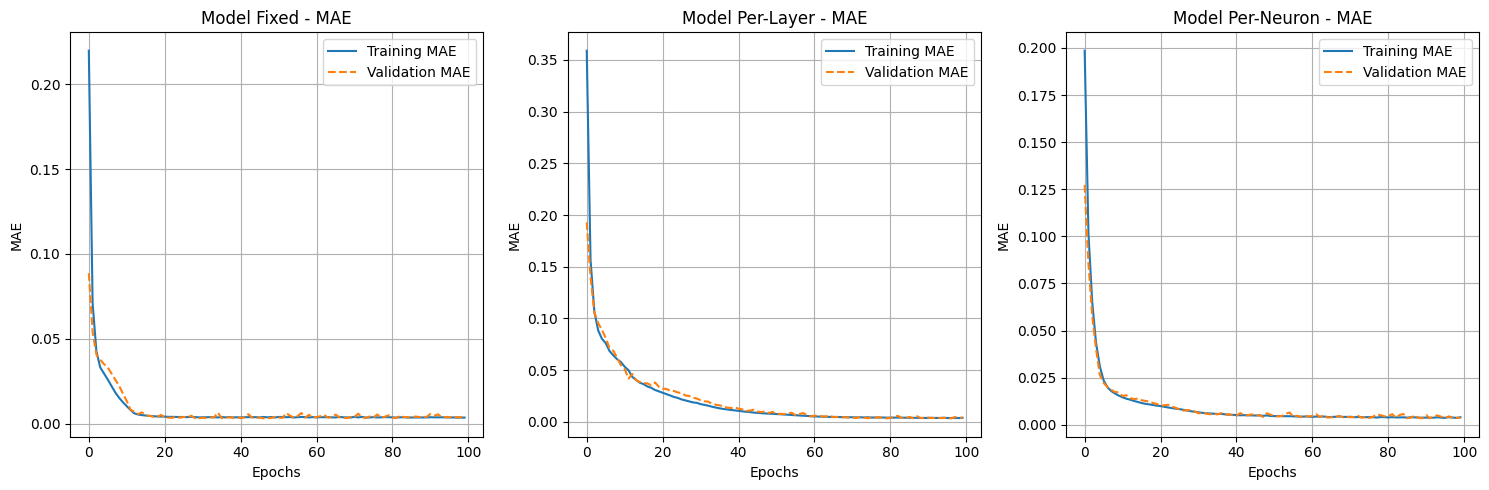

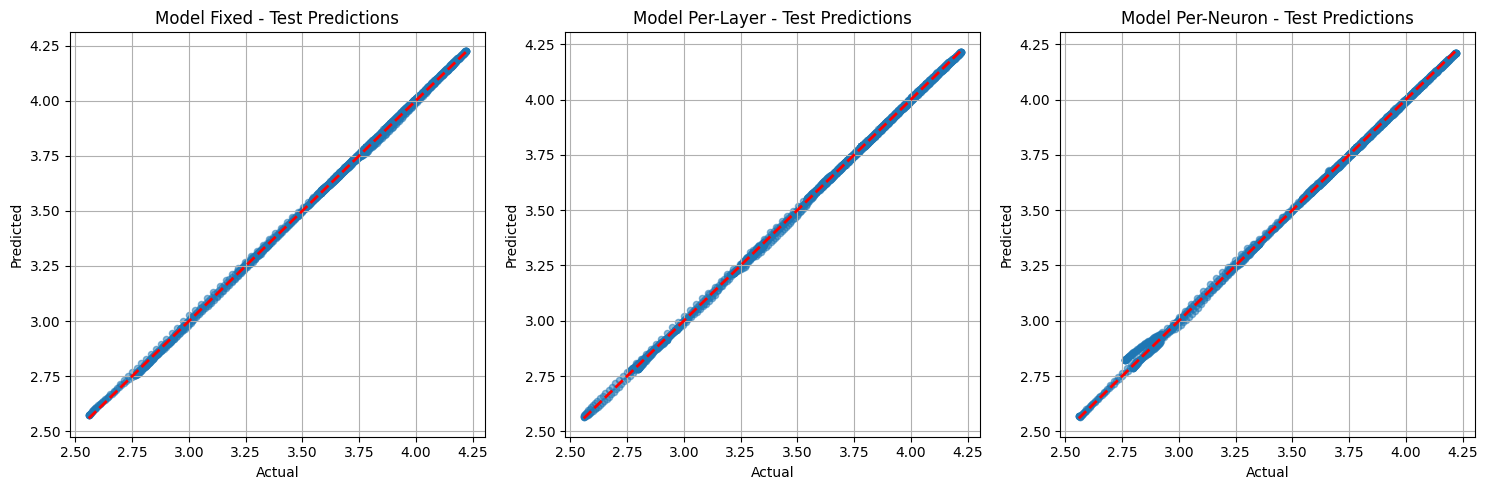

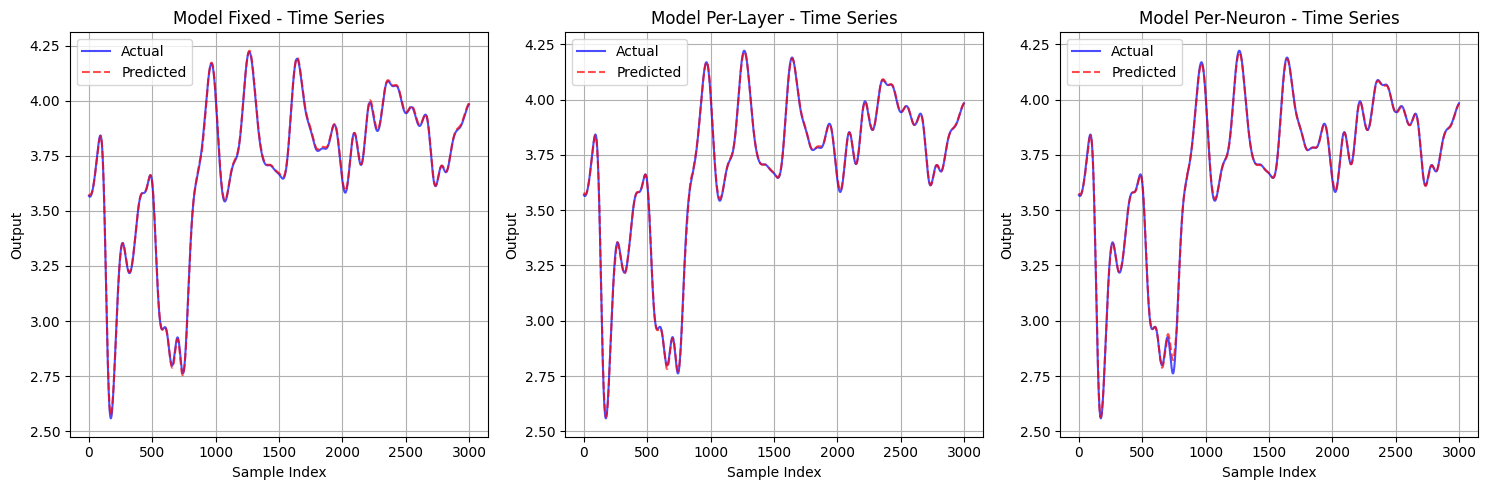

FINAL EVALUATION METRICS
Model Fixed:
  Test MSE: 0.000047
  Test MAE: 0.005598

Model Per-Layer:
  Test MSE: 0.000037
  Test MAE: 0.004450

Model Per-Neuron:
  Test MSE: 0.000082
  Test MAE: 0.005024


In [10]:
# ============== PLOT RESULTS ==============
import matplotlib.pyplot as plt

# 1. Plot training and validation loss
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history_fixed.history['loss'], label='Training Loss')
plt.plot(history_fixed.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model Fixed - Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history_trainable.history['loss'], label='Training Loss')
plt.plot(history_trainable.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model Per-Layer - Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history_adaptable.history['loss'], label='Training Loss')
plt.plot(history_adaptable.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model Per-Neuron - Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 2. Plot training and validation MAE
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history_fixed.history['mae'], label='Training MAE')
plt.plot(history_fixed.history['val_mae'], label='Validation MAE', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Model Fixed - MAE')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history_trainable.history['mae'], label='Training MAE')
plt.plot(history_trainable.history['val_mae'], label='Validation MAE', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Model Per-Layer - MAE')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history_adaptable.history['mae'], label='Training MAE')
plt.plot(history_adaptable.history['val_mae'], label='Validation MAE', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Model Per-Neuron - MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Predictions vs Actual for test set
y_pred_fixed = model_fixed.predict(X_test, verbose=0)
y_pred_trainable = model_trainable.predict(X_test, verbose=0)
y_pred_adaptable = model_adaptable.predict(X_test, verbose=0)

# Inverse transform to original scale
y_test_orig = y_scaler.inverse_transform(y_test)
y_pred_fixed_orig = y_scaler.inverse_transform(y_pred_fixed)
y_pred_trainable_orig = y_scaler.inverse_transform(y_pred_trainable)
y_pred_adaptable_orig = y_scaler.inverse_transform(y_pred_adaptable)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test_orig, y_pred_fixed_orig, alpha=0.5, s=20)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Model Fixed - Test Predictions')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(y_test_orig, y_pred_trainable_orig, alpha=0.5, s=20)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Model Per-Layer - Test Predictions')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.scatter(y_test_orig, y_pred_adaptable_orig, alpha=0.5, s=20)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Model Per-Neuron - Test Predictions')
plt.grid(True)

plt.tight_layout()
plt.show()

# 4. Plot actual vs predicted time series for first 100 samples
plt.figure(figsize=(15, 5))

sample_size = max(100, len(y_test_orig))

plt.subplot(1, 3, 1)
plt.plot(y_test_orig[:sample_size], 'b-', label='Actual', alpha=0.7)
plt.plot(y_pred_fixed_orig[:sample_size], 'r--', label='Predicted', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.title('Model Fixed - Time Series')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(y_test_orig[:sample_size], 'b-', label='Actual', alpha=0.7)
plt.plot(y_pred_trainable_orig[:sample_size], 'r--', label='Predicted', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.title('Model Per-Layer - Time Series')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(y_test_orig[:sample_size], 'b-', label='Actual', alpha=0.7)
plt.plot(y_pred_adaptable_orig[:sample_size], 'r--', label='Predicted', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.title('Model Per-Neuron - Time Series')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 5. Print final evaluation metrics
print("=" * 60)
print("FINAL EVALUATION METRICS")
print("=" * 60)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Model 1
mse1 = mean_squared_error(y_test_orig, y_pred_fixed_orig)
mae1 = mean_absolute_error(y_test_orig, y_pred_fixed_orig)
print(f"Model Fixed:")
print(f"  Test MSE: {mse1:.6f}")
print(f"  Test MAE: {mae1:.6f}")

# Model 2
mse2 = mean_squared_error(y_test_orig, y_pred_trainable_orig)
mae2 = mean_absolute_error(y_test_orig, y_pred_trainable_orig)
print(f"\nModel Per-Layer:")
print(f"  Test MSE: {mse2:.6f}")
print(f"  Test MAE: {mae2:.6f}")

# Model 3
mse3 = mean_squared_error(y_test_orig, y_pred_adaptable_orig)
mae3 = mean_absolute_error(y_test_orig, y_pred_adaptable_orig)
print(f"\nModel Per-Neuron:")
print(f"  Test MSE: {mse3:.6f}")
print(f"  Test MAE: {mae3:.6f}")

print("=" * 60)